# Imports

In [55]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad
import celltypist
import anndata as ad
from scipy import sparse
from anndata import AnnData
import celltypist
import sys  
sys.path.insert(0, '/home/p/pohll/Desktop/Masterpraktikum/masterpraktikum_fibrosis_atlas/source')
#sys.path.append("Desktop/Masterpraktikum/masterpraktikum_fibrosis_atlas/source/utils.py")
import utils

which information should anndatas contain: 
- adata.X --> raw counts
in adata.obs 
- "batch" --> number or name identifying batch/sample
- "author_annotation" --> annotation given by paper
- "manual_celltype_annotation" --> your annotation
- "condition" --> "healthy" or "bleo" or other treatment for fibrosis 
- 'scDblFinder_score' (or other names of doublet ananylsis columns)
- 'scDblFinder_class'

# load data

In [2]:
xie = sc.read("/home/p/pohll/Desktop/MP/data/xie_for_merge.h5ad")
tsukui = sc.read("/home/p/pohll/Desktop/MP/data/tsukui_mini4merge.h5ad")
misharin = sc.read("/home/p/pohll/Desktop/MP/data/misharin_Emma_for_merging.h5ad")

In [3]:
schiller = sc.read("/home/p/pohll/Desktop/MP/data/schiller_whl_for_merge.h5ad")
peyser = sc.read("/home/p/pohll/Desktop/MP/data/Peyser_Merging.h5ad")

## check adatas

In [4]:
print("xie" + str(xie.shape))
print("peyser" + str(peyser.shape))
print("misharin" + str(misharin.shape))
print("tsukui" + str(tsukui.shape))
print("schiller" + str(schiller.shape))

xie(10100, 27998)
peyser(18686, 19472)
misharin(15365, 27998)
tsukui(24881, 18752)
schiller(24071, 23400)


In [5]:
peyser

AnnData object with n_obs × n_vars = 18686 × 19472
    obs: 'batch', 'condition', 'manual_celltype_annotation'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'

In [6]:
del peyser.var

In [7]:
misharin

AnnData object with n_obs × n_vars = 15365 × 27998
    obs: 'batch', 'author_annotation', 'manual_celltype_annotation', 'condition'

In [8]:
schiller

AnnData object with n_obs × n_vars = 24071 × 23400
    obs: 'author_annotation', 'batch', 'condition', 'timepoint', 'manual_celltype_annotation', 'author_annotation_coarse'

#xie.obs = xie.obs.rename(columns={'scDblFinder_score': 'doublet_score', 'scDblFinder_class': 'predicted_doublet'})

# upset plot of genes --> see R

In [10]:
adatas = {
    "xie": xie,
    "peyser": peyser,
    "tsukui": tsukui,
    "misharin": misharin,
    "schiller": schiller,
 }

In [11]:
gene_sets = {key: list(set(adata.var.index)) for key, adata in adatas.items()}

In [12]:
with open("dataset_genes.json", "w") as file:
    json.dump(gene_sets, file)

# Merge 

In [13]:
adatas = {
    "xie": xie,
    "peyser": peyser,
    "tsukui": tsukui,
    "misharin": misharin,
    "schiller": schiller,
 }
adata = ad.concat(adatas, label="dataset", index_unique="_", join="outer", axis = 0)#.obs

In [14]:
adata

AnnData object with n_obs × n_vars = 93103 × 32317
    obs: 'author_annotation', 'scDblFinder_score', 'scDblFinder_class', 'manual_celltype_annotation', 'batch', 'condition', 'doublet_score', 'predicted_doublet', 'timepoint', 'author_annotation_coarse', 'dataset'

### harmonize condition names

In [15]:
sorted(adata.obs["condition"].unique())

['Bleo',
 'UT',
 'asbestos',
 'bleo',
 'bleomycin',
 'control',
 'healthy',
 'nintedanib',
 'saline']

In [16]:
adata.obs["condition"] = adata.obs["condition"].replace(["Bleo", "bleo"], "bleomycin")
adata.obs["condition"] = adata.obs["condition"].replace(["UT", "control", "healthy"], "untreated")

### add fibrotic/control column in obs

In [17]:
adata.obs["fibrotic/control"] = adata.obs["condition"].apply(lambda x: "control" if x == "untreated" else "fibrotic")

In [18]:
#adata.obs["batch"] = str(adata.obs["batch"]) + "_" + str(adata.obs["dataset"])
adata.obs["batch"] = adata.obs.apply(lambda row: str(row["batch"]) + "_" + str(row["dataset"]), axis=1)

### make unique batch keys across datasets 

In [19]:
adata.obs["batch"] = adata.obs["batch"].astype("category")

In [20]:
adata.obs

,author_annotation,scDblFinder_score,scDblFinder_class,manual_celltype_annotation,batch,condition,doublet_score,predicted_doublet,timepoint,author_annotation_coarse,dataset,fibrotic/control
AAACCTGAGGACATTA-1_xie,Col13a1,0.021293,singlet,Myofibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,xie,control
AAACCTGCAGTCGTGC-1_xie,Myofibroblasts,0.000934,singlet,Peribronchial fibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,xie,control
AAACCTGCATGAAGTA-1_xie,Lipofibroblasts,0.000118,singlet,Alveolar macrophages,1_xie,untreated,NaN,NaN,NaN,NaN,xie,control
AAACCTGTCTCGCATC-1_xie,Myofibroblasts,0.000478,singlet,Peribronchial fibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,xie,control
AAACGGGTCCTAGAAC-1_xie,Myofibroblasts,0.000669,singlet,Peribronchial fibroblasts,1_xie,untreated,NaN,NaN,NaN,NaN,xie,control
...,...,...,...,...,...,...,...,...,...,...,...,...
29291_schiller,Ciliated cells,NaN,NaN,Alveolar fibroblast,muc4657_schiller,untreated,NaN,NaN,d21,ciliated_cells,schiller,control
29292_schiller,AT2 cells,NaN,NaN,AT2,muc4657_schiller,untreated,NaN,NaN,d21,alv_epithelium,schiller,control
29293_schiller,Ciliated cells,NaN,NaN,Alveolar fibroblast,muc4657_schiller,untreated,NaN,NaN,d21,ciliated_cells,schiller,control
29294_schiller,AT2 cells,NaN,NaN,AT2,muc4657_schiller,untreated,NaN,NaN,d21,alv_epithelium,schiller,control


### write adata

In [21]:
adata.obs["predicted_doublet"] = adata.obs["predicted_doublet"].astype("category")

In [22]:
adata.write("/home/p/pohll/Desktop/MP/data/merged_data.h5ad")
#dataset = sc.read("/home/p/pohll/Desktop/MP/data/merged_data.h5ad")

... storing 'fibrotic/control' as categorical


# QC

## calculate qc metrics 

In [23]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith(("MT-", "mt-"))
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL", "rps", "rpl"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [24]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 93103 × 32317
    obs: 'author_annotation', 'scDblFinder_score', 'scDblFinder_class', 'manual_celltype_annotation', 'batch', 'condition', 'doublet_score', 'predicted_doublet', 'timepoint', 'author_annotation_coarse', 'dataset', 'fibrotic/control', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## QC covariates for all datasets

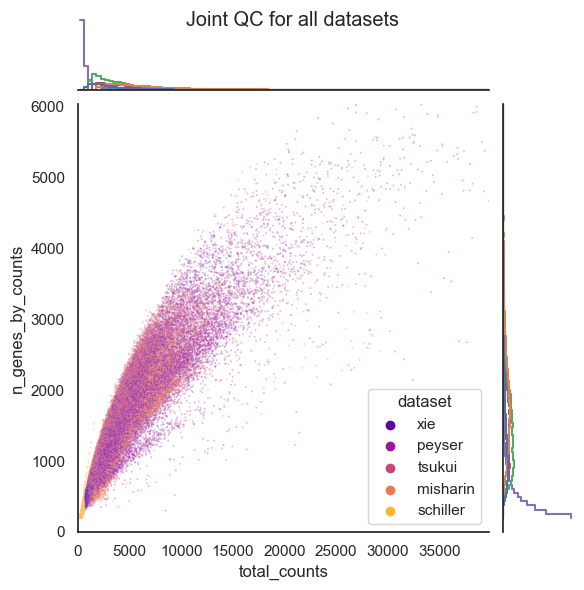

In [26]:
utils.plot_qc_joint(adata, x="total_counts",
                    y='n_genes_by_counts', 
                    hue='dataset', #"dataset",#
                    palette='plasma',
                    marginal_hue="dataset",
                    #x_threshold=(300, 4000), #  total_counts
                    #y_threshold=(0, 17000), # n_genes_by_counts
                    title='Joint QC for all datasets' ) # one for all dataset, colour by dataset 

## QC covariates for Schiller 

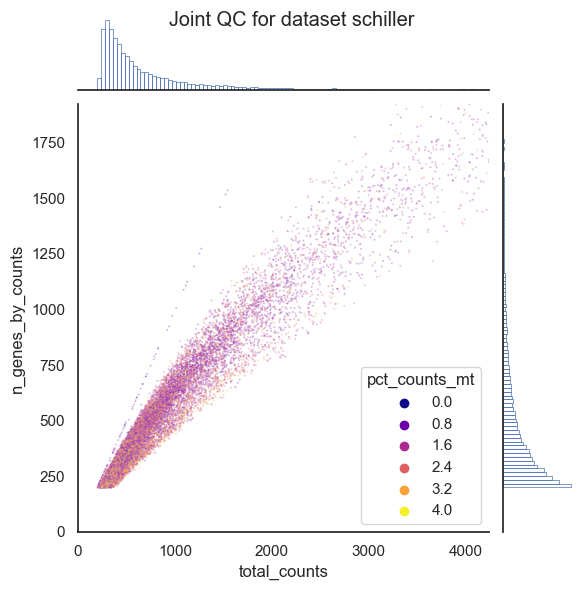

In [25]:
datasets = ["xie", "tsukui","misharin", "peyser", "schiller" ]# todo "schiller"
#for x in datasets: 
subset = adata[adata.obs['dataset'] == "schiller"]
utils.plot_qc_joint(subset, x="total_counts",
                    y='n_genes_by_counts', 
                    hue='pct_counts_mt', 
                   palette='plasma',
                   #marginal_hue="dataset",
                   #x_threshold=(300, 4000), #  total_counts
                  #y_threshold=(0, 17000), # n_genes_by_counts
                  title='Joint QC for dataset schiller') # one for all dataset, colour by dataset 

<AxesSubplot: xlabel='total_counts', ylabel='Count'>

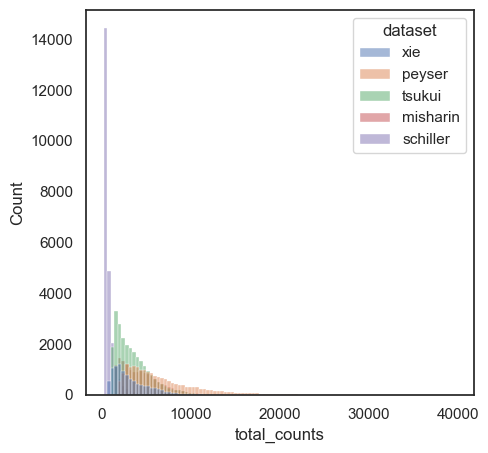

In [61]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.histplot(
    adata.obs, x="total_counts", hue="dataset",bins=100, kde=False, legend = True
)

schiller used other protocol (dropseq), all the others used 10x chromium v2 --> Schiller data has different count distribution, more cells with lower total_counts

# Normalization

In [29]:
scales_counts = sc.pp.normalize_total(adata, target_sum=None, inplace=False)
# log1p transform
adata.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

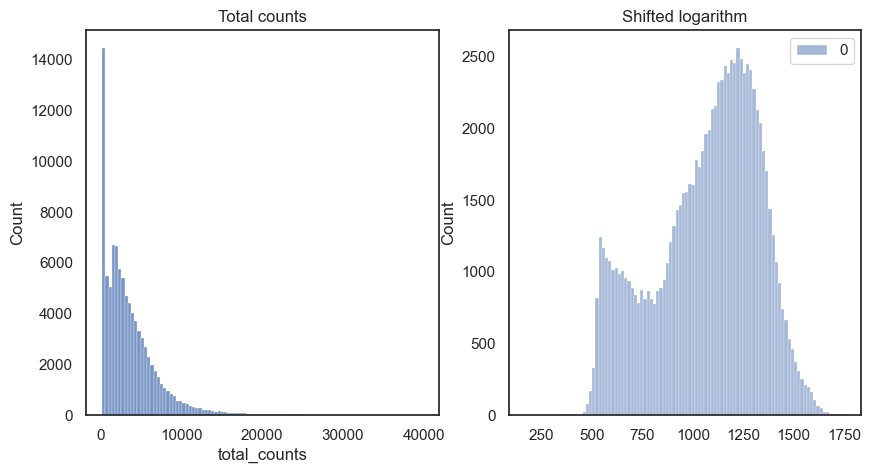

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata.obs["total_counts"], bins=100, kde=False, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

left peak due to Schiller data

In [31]:
adata.layers["raw_counts"] = adata.X

In [32]:
adata

AnnData object with n_obs × n_vars = 93103 × 32317
    obs: 'author_annotation', 'scDblFinder_score', 'scDblFinder_class', 'manual_celltype_annotation', 'batch', 'condition', 'doublet_score', 'predicted_doublet', 'timepoint', 'author_annotation_coarse', 'dataset', 'fibrotic/control', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'log1p_norm', 'raw_counts'

# Feature Selection

In [33]:
sc.pp.log1p(adata)

!! use batch_key="dataset" to extract highly_variable_genes

In [34]:
sc.pp.highly_variable_genes(adata, min_mean=0.0120, max_mean=3, min_disp=0.5, batch_key="dataset")

In [35]:
plt.rcParams['figure.figsize'] = (5,5)

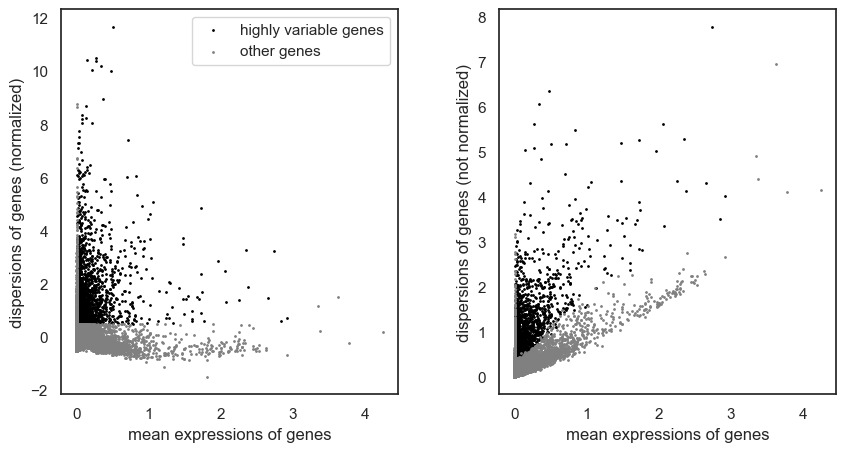

In [36]:
sc.pl.highly_variable_genes(adata)

# Dim Reduction & UMAP 

## PCA

In [37]:
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True )

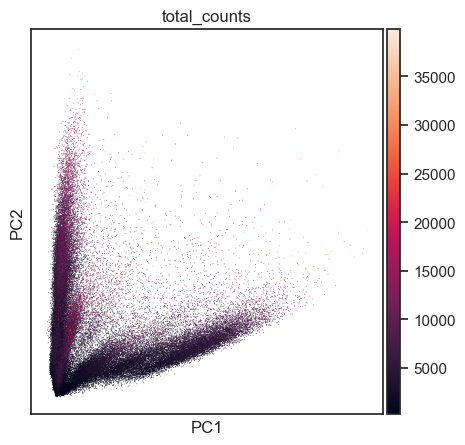

In [38]:
sc.pl.pca(adata, color='total_counts')

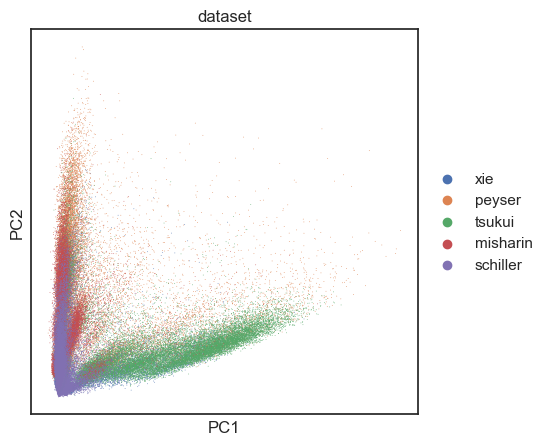

In [39]:
sc.pl.pca(adata, color="dataset")

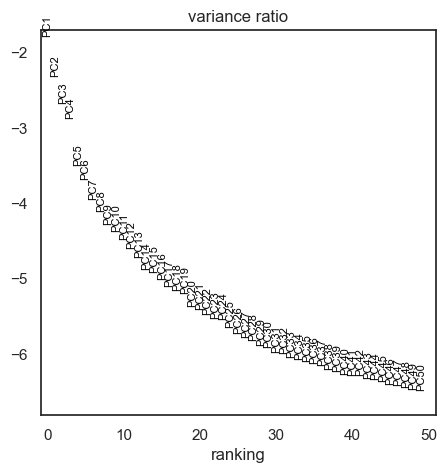

In [42]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50) # später rufe neighbours/UMAP mit verschiedenen PCs auf 

## UMAP (total_count, datasets)

In [43]:
sc.pp.neighbors(adata,n_pcs = 40) 
sc.tl.umap(adata)

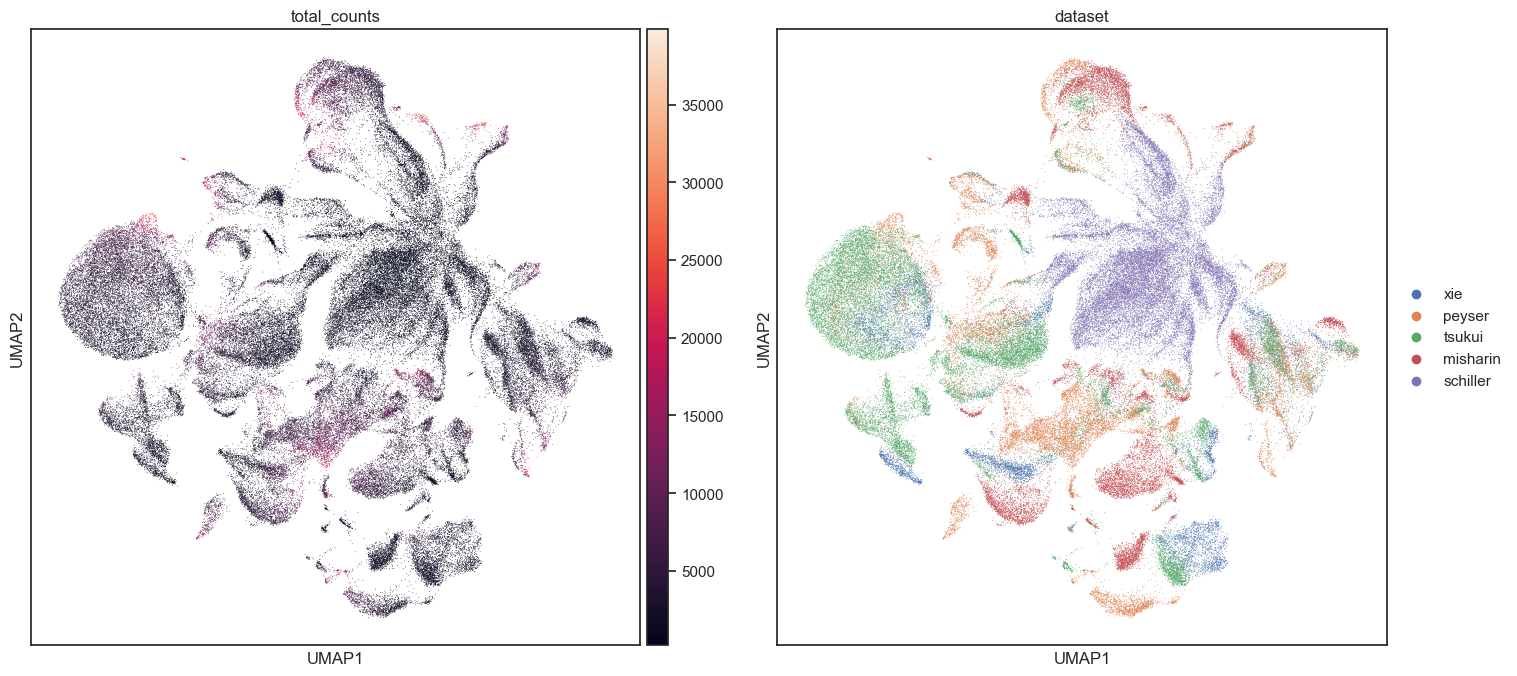

In [46]:
sc.pl.umap(adata, color=["total_counts", "dataset"])

schiller data points do not form nice clusters, like one big star shaped cluster in the middle, 
other datasets (better cluster formation): show batch effect but some clusters also have an overlap

## harmonize manual annotation names

look for typos

In [53]:
sorted(adata.obs["manual_celltype_annotation"].unique())

['AT1',
 'AT2',
 'Adventitial fibroblasts',
 'Aerocytes',
 'Alveolar fibroblasts',
 'Alveolar macrophages',
 'B-cells',
 'CD4 T-cells',
 'Classical monocytes',
 'Dendritic cells',
 'Dendritic cells Ccr7-hi',
 'Dendritic cells pDC',
 'Endothelial',
 'Epithelial',
 'Interstitial macrophages',
 'Lymphatic endothelial',
 'Myofibroblasts',
 'NA',
 'NK cells',
 'Neutrophils',
 'Non-classical monocytes',
 'Peribronchial fibroblasts',
 'SMCs',
 'T-cells',
 'Transitioning epithelial']

In [52]:
adata.obs["manual_celltype_annotation"] = adata.obs["manual_celltype_annotation"].replace(["Adventitial fibroblast"], "Adventitial fibroblasts")
adata.obs["manual_celltype_annotation"].fillna("NA", inplace=True)
adata.obs["manual_celltype_annotation"] = adata.obs["manual_celltype_annotation"].replace(["T-Cells"], "T-cells")
adata.obs["manual_celltype_annotation"] = adata.obs["manual_celltype_annotation"].replace(["Alveolar fibroblast"], "Alveolar fibroblasts")
adata.obs["manual_celltype_annotation"] = adata.obs["manual_celltype_annotation"].replace(["Aerocyte"], "Aerocytes")
adata.obs["manual_celltype_annotation"] = adata.obs["manual_celltype_annotation"].replace(["Dendritic cell CCR7"], "Dendritic cells Ccr7-hi")
adata.obs["manual_celltype_annotation"] = adata.obs["manual_celltype_annotation"].replace(["Interstitial Macrophage"], "Interstitial macrophages")
adata.obs["manual_celltype_annotation"] = adata.obs["manual_celltype_annotation"].replace(["SMCS"], "SMCs")
adata.obs["manual_celltype_annotation"] = adata.obs["manual_celltype_annotation"].replace(["undefined"], "NA")
adata.obs["manual_celltype_annotation"] = adata.obs["manual_celltype_annotation"].replace(["Dendritic"], "Dendritic cells")


## manual annotation in UMAP

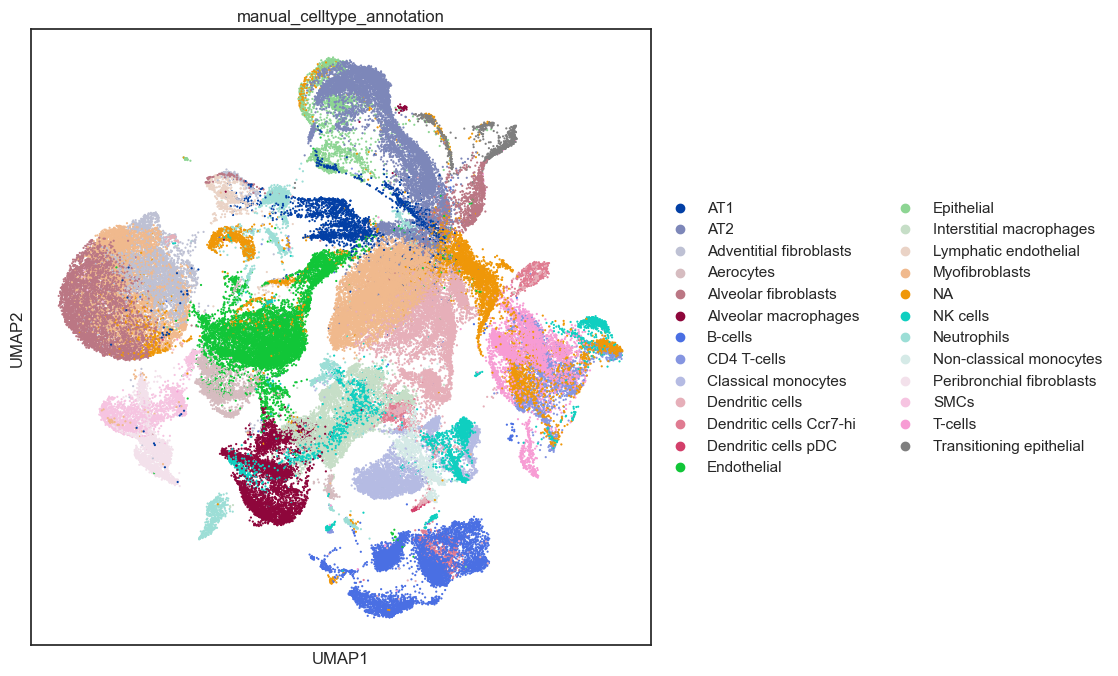

In [54]:
sc.pl.umap(adata, color=['manual_celltype_annotation'], size=10)

In [56]:
adata.write("/home/p/pohll/Desktop/MP/data/merged_data.h5ad")

In [3]:
#adata = sc.read("/home/p/pohll/Desktop/MP/data/merged_data.h5ad")

# harmonization using celltypist

In [57]:
import celltypist

## alignment 

In [58]:
alignment = celltypist.harmonize(adata, 'dataset', 'manual_celltype_annotation')


👀 Detected PCA coordinates in the object, will use these to calculate distances
🏆 Reordering datasets
🖇 Harmonizing cell types of tsukui and xie
🖇 Harmonizing cell types of misharin
🖇 Harmonizing cell types of peyser
🖇 Harmonizing cell types of schiller
🖋️ Reannotating cells
✅ Harmonization done!


In [59]:
alignment

Cross-dataset cell type alignment for 5 datasets
    base_distance: a cross-dataset distance object
    aligned_datasets: 'tsukui', 'xie', 'misharin', 'peyser', 'schiller'
    relation: data frame of the harmonization table
    reannotation: data frame of the reannotated cells ('dataset', 'cell_type', 'reannotation', 'group')

In [63]:
alignment.write('/home/p/pohll/Desktop/MP/data/celltypist_alignment.pkl')

In [64]:
alignment.relation

,tsukui,relation,xie,relation,misharin,relation,peyser,relation,schiller
0,Adventitial fibroblasts,∈,Myofibroblasts,∈,Myofibroblasts,∈,Adventitial fibroblasts,=,NONE
1,Aerocytes,=,Aerocytes,=,Aerocytes,∈,Endothelial,=,NONE
2,Alveolar fibroblasts,∈,Myofibroblasts,∈,Myofibroblasts,∈,Adventitial fibroblasts,=,NONE
3,B-cells,=,Dendritic cells Ccr7-hi,∈,B-cells,=,B-cells,=,NONE
4,Dendritic cells,=,Dendritic cells,=,Dendritic cells,=,Dendritic cells,=,NONE
5,Endothelial,=,Endothelial,=,Endothelial,∈,Endothelial,=,NONE
6,Myofibroblasts,=,NONE,=,UNRESOLVED,∈,Adventitial fibroblasts,=,NONE
7,NA,=,NK cells,=,NK cells,=,UNRESOLVED,=,NONE
8,NK cells,∋,Classical monocytes,∋,Classical monocytes,∈,Classical monocytes,=,NONE
9,NK cells,∋,Classical monocytes,∋,Non-classical monocytes,∈,Classical monocytes,=,NONE


In [65]:
alignment.reannotation

,dataset,cell_type,reannotation,group
ID,,,,
AAACCTGAGGACATTA-1_xie,xie,Myofibroblasts,Adventitial fibroblasts ∈ Myofibroblasts ∈ Myo...,Group1
AAACCTGCAGTCGTGC-1_xie,xie,Peribronchial fibroblasts,Peribronchial fibroblasts = Peribronchial fibr...,Group13
AAACCTGCATGAAGTA-1_xie,xie,Alveolar macrophages,UNRESOLVED = Alveolar macrophages = Alveolar m...,Group16
AAACCTGTCTCGCATC-1_xie,xie,Peribronchial fibroblasts,Peribronchial fibroblasts = Peribronchial fibr...,Group13
AAACGGGTCCTAGAAC-1_xie,xie,Peribronchial fibroblasts,Peribronchial fibroblasts = Peribronchial fibr...,Group13
...,...,...,...,...
29291_schiller,schiller,Alveolar fibroblasts,UNRESOLVED = UNRESOLVED = UNRESOLVED = UNRESOL...,Group20
29292_schiller,schiller,AT2,Epithelial = AT2 = AT2 ∈ Epithelial = AT2,Group7
29293_schiller,schiller,Alveolar fibroblasts,UNRESOLVED = UNRESOLVED = UNRESOLVED = UNRESOL...,Group20


In [79]:
alignment.reannotation["group"].unique()

array(['Group1', 'Group13', 'Group16', 'Group4', 'Group2', 'Group15',
       'Group3', 'Group6', 'Group5', 'Group18', 'Group7', 'Group12',
       'Group14', 'Group8', 'Group17', 'Group9', 'Group10', 'Group11',
       'Group21', 'Group19', 'Group20', 'Group22'], dtype=object)

In [66]:
adata.obs[['low_hierarchy', 'high_hierarchy']] = alignment.reannotation.loc[adata.obs_names, ['reannotation', 'group']]

## visualize alignment distances 

In [67]:
dist_mat = alignment.base_distance.to_meta()
member_mat = alignment.base_distance.to_meta(turn_binary = True)

In [71]:
plt.figure(figsize=(3,3))

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

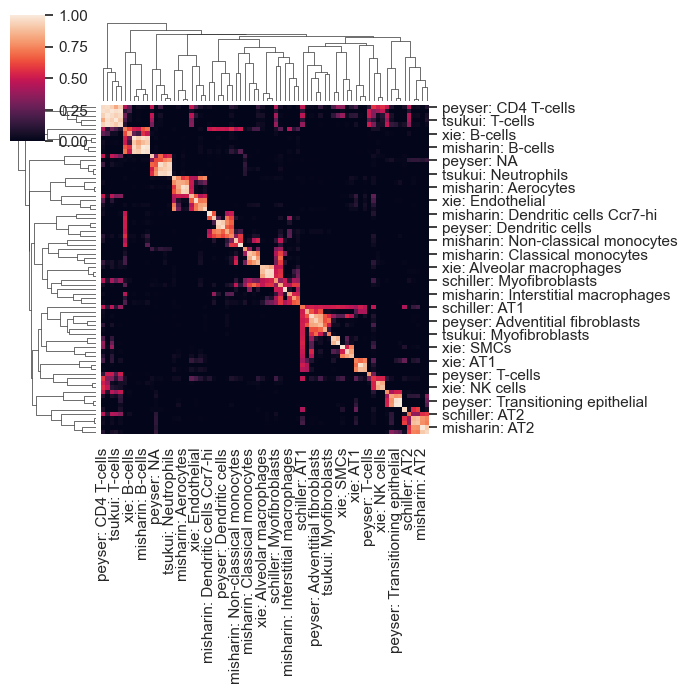

In [74]:
sns.clustermap(member_mat, figsize=(7, 7))

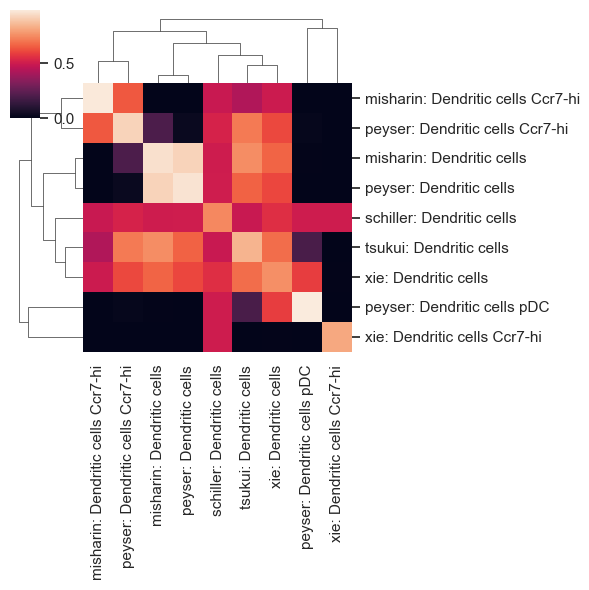

In [76]:
flag = member_mat.index.str.contains('Dendritic')
sns.clustermap(member_mat.loc[flag,flag], figsize=(6, 6))

## alignment treeplot

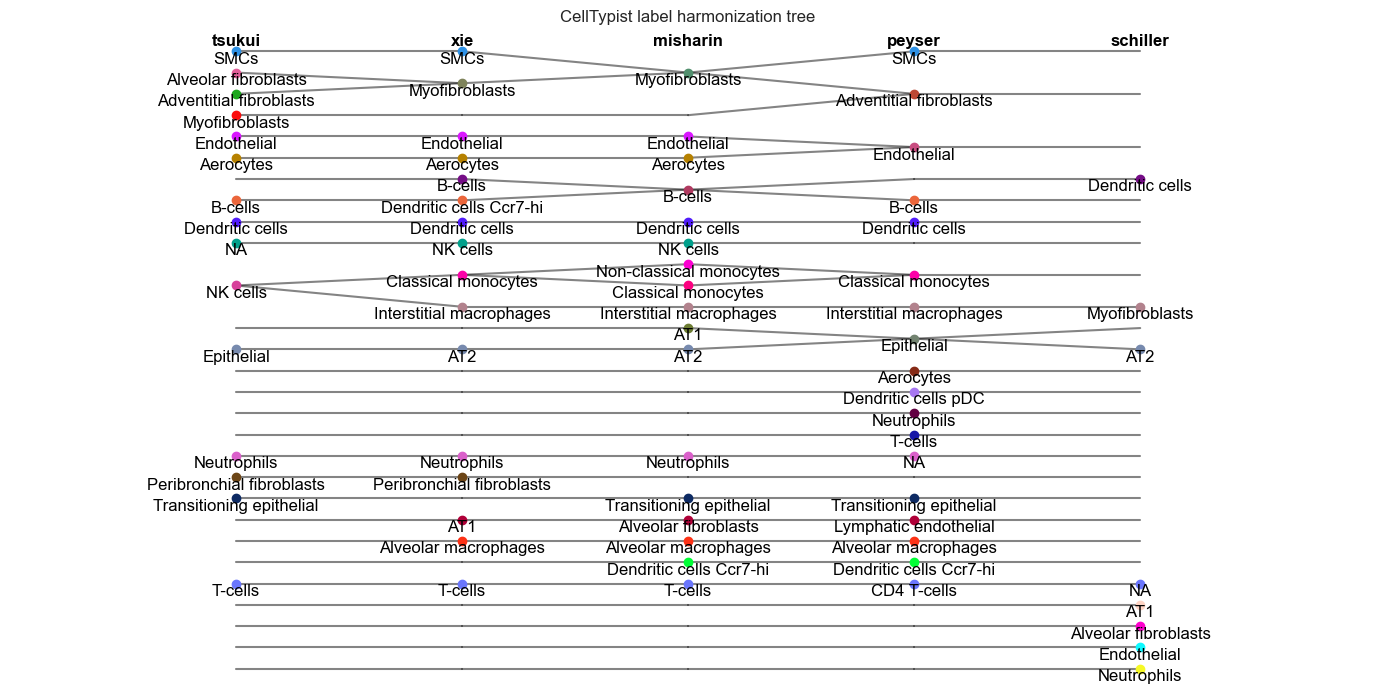

In [77]:
celltypist.treeplot(alignment)

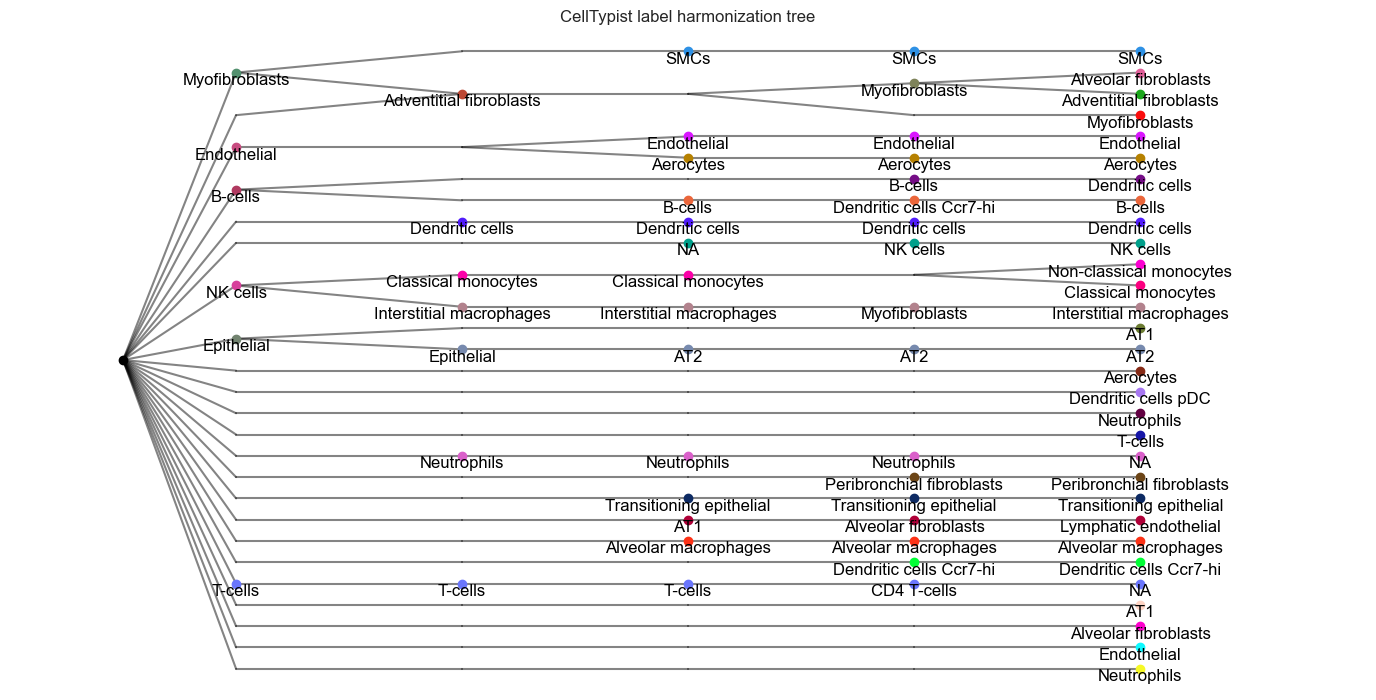

In [78]:
celltypist.treeplot(alignment, order_dataset = True)

In [92]:
alignment

Cross-dataset cell type alignment for 5 datasets
    base_distance: a cross-dataset distance object
    aligned_datasets: 'tsukui', 'xie', 'misharin', 'peyser', 'schiller'
    relation: data frame of the harmonization table
    reannotation: data frame of the reannotated cells ('dataset', 'cell_type', 'reannotation', 'group')

In [80]:
import plotly.io as pio
pio.renderers.default = "iframe"

In [93]:
#alignment = celltypist.DistanceAlignment.load('/home/p/pohll/Desktop/MP/data/celltypist_alignment.pkl')
#celltypist.sankeyplot(alignment)